### **Import Data**

In [11]:
# Mengimpor pustaka google_play_scraper untuk mengakses ulasan dan informasi aplikasi dari Google Play Store.
from google_play_scraper import app, reviews, Sort, reviews_all
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import random
import time
import re


### **Data Splitting dan Ekstraksi Fitur dengan TF-IDF**


Data ulasan WhatsApp dengan label sentimen berhasil dimuat.

Label yang di-encode: {'negative': 0, 'neutral': 1, 'positive': 2}

--- Informasi Distribusi Kelas ---
Distribusi Kelas Asli:
sentiment_lexicon_updated
positive    4037
negative    3994
neutral     2969
Name: count, dtype: int64


--- Skema Pelatihan 1: Logistic Regression + TF-IDF (80/20) ---
Ukuran Data Training: (8800,), (8800,)
Ukuran Data Testing: (2200,), (2200,)

Distribusi Kelas Training:
positive    3230
negative    3195
neutral     2375
Name: count, dtype: int64

Distribusi Kelas Testing:
positive    807
negative    799
neutral     594
Name: count, dtype: int64

Ukuran Vocabulary TF-IDF: 6994
Waktu Vectorisasi TF-IDF: 0.22 detik
Waktu Pelatihan Logistic Regression: 0.49 detik
Akurasi Training Set (Logistic Regression + TF-IDF): 0.9559
Akurasi Testing Set (Logistic Regression + TF-IDF): 0.9186

Laporan Klasifikasi (Logistic Regression + TF-IDF):
              precision    recall  f1-score   support

    negative    

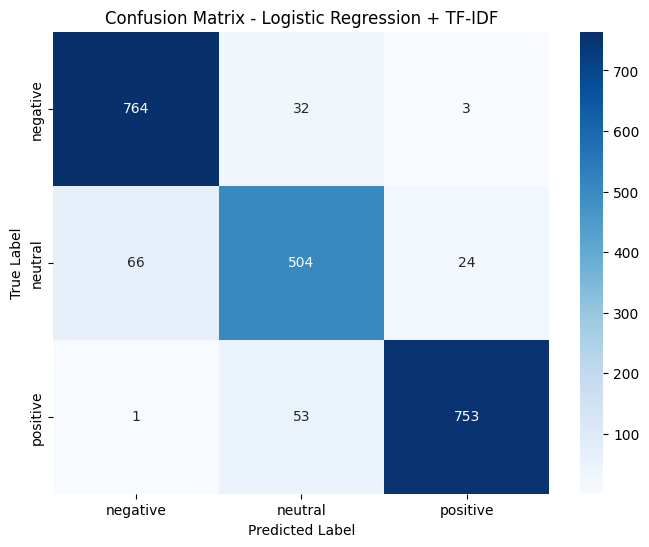



--- Skema Pelatihan 2: SVM + TF-IDF (80/20) ---
Ukuran Data Training: (8800,), (8800,)
Ukuran Data Testing: (2200,), (2200,)

Distribusi Kelas Training:
positive    3230
negative    3195
neutral     2375
Name: count, dtype: int64

Distribusi Kelas Testing:
positive    807
negative    799
neutral     594
Name: count, dtype: int64

Ukuran Vocabulary TF-IDF: 6994
Waktu Vectorisasi TF-IDF: 0.17 detik
Waktu Pelatihan SVM: 4.26 detik
Akurasi Training Set (SVM + TF-IDF): 0.9769
Akurasi Testing Set (SVM + TF-IDF): 0.9323

Laporan Klasifikasi (SVM + TF-IDF):
              precision    recall  f1-score   support

    negative       0.92      0.96      0.94       799
     neutral       0.89      0.87      0.88       594
    positive       0.98      0.95      0.96       807

    accuracy                           0.93      2200
   macro avg       0.93      0.93      0.93      2200
weighted avg       0.93      0.93      0.93      2200



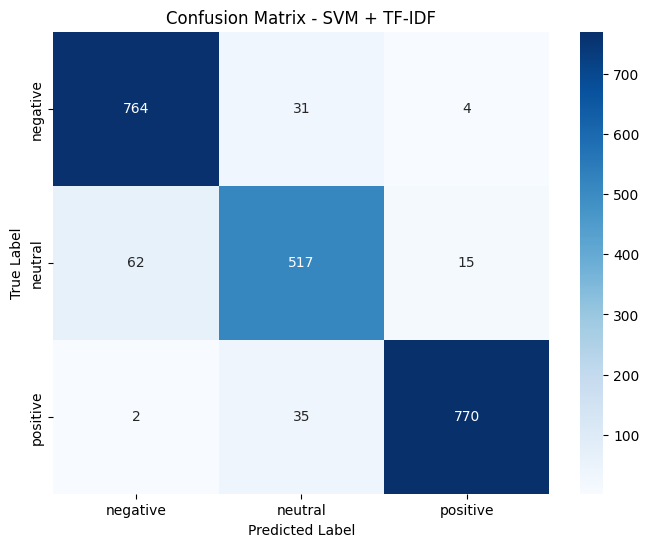



--- Skema Pelatihan 3: Random Forest + CountVectorizer (70/30) ---
Ukuran Data Training: (7700,), (7700,)
Ukuran Data Testing: (3300,), (3300,)

Distribusi Kelas Training:
positive    2826
negative    2796
neutral     2078
Name: count, dtype: int64

Distribusi Kelas Testing:
positive    1211
negative    1198
neutral      891
Name: count, dtype: int64

Ukuran Vocabulary CountVectorizer: 6430
Waktu Vectorisasi CountVectorizer: 0.14 detik
Waktu Pelatihan Random Forest: 6.73 detik
Akurasi Training Set (Random Forest + CountVectorizer): 0.9977
Akurasi Testing Set (Random Forest + CountVectorizer): 0.8909

Laporan Klasifikasi (Random Forest + CountVectorizer):
              precision    recall  f1-score   support

    negative       0.84      0.97      0.90      1198
     neutral       0.87      0.79      0.82       891
    positive       0.98      0.89      0.93      1211

    accuracy                           0.89      3300
   macro avg       0.89      0.88      0.88      3300
weighted 

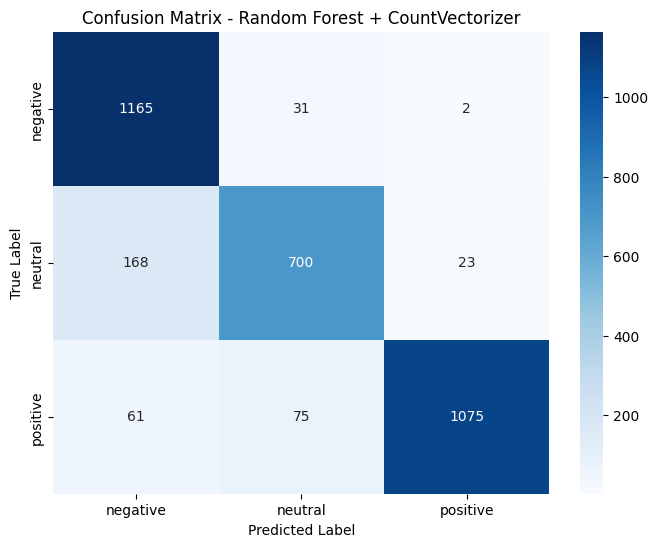

In [12]:
try:
    df_train = pd.read_csv('ulasan_aplikasi.csv')
    if 'content' not in df_train.columns or 'sentiment_lexicon_updated' not in df_train.columns:
        print("\nKolom 'content' atau 'sentiment_lexicon_updated' tidak ditemukan di dataset.")
        df_train = None
    else:
        print("\nData ulasan WhatsApp dengan label sentimen berhasil dimuat.")
except FileNotFoundError:
    print("\nFile ulasan_aplikasi.csv tidak ditemukan. Pastikan file berada di direktori yang sama.")
    df_train = None

if df_train is not None:
    # Memisahkan Fitur (Teks Ulasan) dan Target (Label Sentimen)
    X = df_train['content']
    y = df_train['sentiment_lexicon_updated']

    # Encode Label Sentimen menjadi Numerik
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    class_names = label_encoder.classes_
    print(f"\nLabel yang di-encode: {dict(zip(class_names, range(len(class_names))))}")

    print("\n--- Informasi Distribusi Kelas ---")
    print("Distribusi Kelas Asli:")
    print(pd.Series(y).value_counts())

    # Skema Pelatihan 1: Logistic Regression + TF-IDF (80/20) ---
    print("\n\n--- Skema Pelatihan 1: Logistic Regression + TF-IDF (80/20) ---")
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
    print(f"Ukuran Data Training: {X_train1.shape}, {y_train1.shape}")
    print(f"Ukuran Data Testing: {X_test1.shape}, {y_test1.shape}")
    print("\nDistribusi Kelas Training:")
    print(pd.Series(label_encoder.inverse_transform(y_train1)).value_counts())
    print("\nDistribusi Kelas Testing:")
    print(pd.Series(label_encoder.inverse_transform(y_test1)).value_counts())

    tfidf_vectorizer1 = TfidfVectorizer()
    start_time = time.time()
    X_train_tfidf1 = tfidf_vectorizer1.fit_transform(X_train1)
    X_test_tfidf1 = tfidf_vectorizer1.transform(X_test1)
    print(f"\nUkuran Vocabulary TF-IDF: {len(tfidf_vectorizer1.vocabulary_)}")
    print(f"Waktu Vectorisasi TF-IDF: {time.time() - start_time:.2f} detik")

    model_lr = LogisticRegression(max_iter=1000, random_state=42)
    start_time = time.time()
    model_lr.fit(X_train_tfidf1, y_train1)
    print(f"Waktu Pelatihan Logistic Regression: {time.time() - start_time:.2f} detik")

    y_pred_train_lr = model_lr.predict(X_train_tfidf1)
    accuracy_train_lr = accuracy_score(y_train1, y_pred_train_lr)
    print(f"Akurasi Training Set (Logistic Regression + TF-IDF): {accuracy_train_lr:.4f}")

    y_pred_lr = model_lr.predict(X_test_tfidf1)
    accuracy_lr = accuracy_score(y_test1, y_pred_lr)
    print(f"Akurasi Testing Set (Logistic Regression + TF-IDF): {accuracy_lr:.4f}")
    print("\nLaporan Klasifikasi (Logistic Regression + TF-IDF):")
    print(classification_report(y_test1, y_pred_lr, target_names=class_names))

    cm_lr = confusion_matrix(y_test1, y_pred_lr)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Logistic Regression + TF-IDF')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Skema Pelatihan 2: SVM + TF-IDF (80/20)
    print("\n\n--- Skema Pelatihan 2: SVM + TF-IDF (80/20) ---")
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
    print(f"Ukuran Data Training: {X_train2.shape}, {y_train2.shape}")
    print(f"Ukuran Data Testing: {X_test2.shape}, {y_test2.shape}")
    print("\nDistribusi Kelas Training:")
    print(pd.Series(label_encoder.inverse_transform(y_train2)).value_counts())
    print("\nDistribusi Kelas Testing:")
    print(pd.Series(label_encoder.inverse_transform(y_test2)).value_counts())

    tfidf_vectorizer2 = TfidfVectorizer()
    start_time = time.time()
    X_train_tfidf2 = tfidf_vectorizer2.fit_transform(X_train2)
    X_test_tfidf2 = tfidf_vectorizer2.transform(X_test2)
    print(f"\nUkuran Vocabulary TF-IDF: {len(tfidf_vectorizer2.vocabulary_)}")
    print(f"Waktu Vectorisasi TF-IDF: {time.time() - start_time:.2f} detik")

    model_svm = SVC(kernel='linear', random_state=42)
    start_time = time.time()
    model_svm.fit(X_train_tfidf2, y_train2)
    print(f"Waktu Pelatihan SVM: {time.time() - start_time:.2f} detik")

    y_pred_train_svm = model_svm.predict(X_train_tfidf2)
    accuracy_train_svm = accuracy_score(y_train2, y_pred_train_svm)
    print(f"Akurasi Training Set (SVM + TF-IDF): {accuracy_train_svm:.4f}")

    y_pred_svm = model_svm.predict(X_test_tfidf2)
    accuracy_svm = accuracy_score(y_test2, y_pred_svm)
    print(f"Akurasi Testing Set (SVM + TF-IDF): {accuracy_svm:.4f}")
    print("\nLaporan Klasifikasi (SVM + TF-IDF):")
    print(classification_report(y_test2, y_pred_svm, target_names=class_names))

    cm_svm = confusion_matrix(y_test2, y_pred_svm)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - SVM + TF-IDF')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # --- Skema Pelatihan 3: Random Forest + CountVectorizer (70/30) ---
    print("\n\n--- Skema Pelatihan 3: Random Forest + CountVectorizer (70/30) ---")
    X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
    print(f"Ukuran Data Training: {X_train3.shape}, {y_train3.shape}")
    print(f"Ukuran Data Testing: {X_test3.shape}, {y_test3.shape}")
    print("\nDistribusi Kelas Training:")
    print(pd.Series(label_encoder.inverse_transform(y_train3)).value_counts())
    print("\nDistribusi Kelas Testing:")
    print(pd.Series(label_encoder.inverse_transform(y_test3)).value_counts())

    count_vectorizer = CountVectorizer()
    start_time = time.time()
    X_train_counts = count_vectorizer.fit_transform(X_train3)
    X_test_counts = count_vectorizer.transform(X_test3)
    print(f"\nUkuran Vocabulary CountVectorizer: {len(count_vectorizer.vocabulary_)}")
    print(f"Waktu Vectorisasi CountVectorizer: {time.time() - start_time:.2f} detik")

    model_rf = RandomForestClassifier(random_state=42)
    start_time = time.time()
    model_rf.fit(X_train_counts, y_train3)
    print(f"Waktu Pelatihan Random Forest: {time.time() - start_time:.2f} detik")

    y_pred_train_rf = model_rf.predict(X_train_counts)
    accuracy_train_rf = accuracy_score(y_train3, y_pred_train_rf)
    print(f"Akurasi Training Set (Random Forest + CountVectorizer): {accuracy_train_rf:.4f}")

    y_pred_rf = model_rf.predict(X_test_counts)
    accuracy_rf = accuracy_score(y_test3, y_pred_rf)
    print(f"Akurasi Testing Set (Random Forest + CountVectorizer): {accuracy_rf:.4f}")
    print("\nLaporan Klasifikasi (Random Forest + CountVectorizer):")
    print(classification_report(y_test3, y_pred_rf, target_names=class_names))

    cm_rf = confusion_matrix(y_test3, y_pred_rf)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Random Forest + CountVectorizer')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [13]:
# Penggujian menggunakan Bi-GRU

# Set seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load Data
cleaned_reviews_df = pd.read_csv('ulasan_aplikasi.csv')

# Preprocessing function
def clean_tokens(text):
    tokens = word_tokenize(text)
    cleaned_tokens = [token.strip(string.punctuation) for token in tokens if token.strip(string.punctuation)]
    return " ".join(cleaned_tokens)

cleaned_reviews_df['text_cleaned'] = cleaned_reviews_df['text_stopword'].apply(clean_tokens)

# Build Vocabulary
all_tokens = [word for text in cleaned_reviews_df['text_cleaned'] for word in word_tokenize(text)]
word_counts = Counter(all_tokens)
vocabulary = list(word_counts.keys())
word_index = {word: idx + 1 for idx, word in enumerate(vocabulary)}
word_index["<unk>"] = 0

# Convert text to sequences
def text_to_sequence(text, word_index):
    return [word_index.get(token, 0) for token in word_tokenize(text)]

cleaned_reviews_df['text_sequence'] = cleaned_reviews_df['text_cleaned'].apply(lambda x: text_to_sequence(x, word_index))

# Padding sequences
max_len = 50
def pad_sequences_numpy(sequences, max_len):
    return np.array([seq[:max_len] + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences])

sequences = cleaned_reviews_df['text_sequence'].tolist()
padded_sequences = pad_sequences_numpy(sequences, max_len)

# Encode Labels
label_encoder = LabelEncoder()
cleaned_reviews_df['sentiment_encoded'] = label_encoder.fit_transform(cleaned_reviews_df['sentiment_lexicon_updated'])
labels = cleaned_reviews_df['sentiment_encoded'].values

# Split Data
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# PyTorch Dataset class
class SentimentDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(SentimentDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(SentimentDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(SentimentDataset(X_test, y_test), batch_size=batch_size)

# Define BiGRU Model
class BiGRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(BiGRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, bidirectional=True, dropout=0.3, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        last_output = gru_out[:, -1, :]
        return self.fc(last_output)

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(word_index) + 1
embedding_dim = 100
hidden_dim = 64
output_dim = 3
model = BiGRUModel(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)

# Define Loss Function and Optimizer
class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

# Evaluate Model
def evaluate_model(loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return correct / total, all_preds, all_labels

# Validation Accuracy
val_acc, _, _ = evaluate_model(val_loader)
print(f'Validation Accuracy: {val_acc:.4f}')

# Test Accuracy & Metrics
test_acc, y_pred, y_true = evaluate_model(test_loader)
print(f'Test Accuracy: {test_acc:.4f}')
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=label_encoder.classes_))

Epoch [1/10], Loss: 0.8588
Epoch [2/10], Loss: 0.3169
Epoch [3/10], Loss: 0.1671
Epoch [4/10], Loss: 0.0857
Epoch [5/10], Loss: 0.0529
Epoch [6/10], Loss: 0.0363
Epoch [7/10], Loss: 0.0217
Epoch [8/10], Loss: 0.0181
Epoch [9/10], Loss: 0.0128
Epoch [10/10], Loss: 0.0102
Validation Accuracy: 0.9436
Test Accuracy: 0.9618
Classification Report:
               precision    recall  f1-score   support

    negative       0.97      0.97      0.97       400
     neutral       0.92      0.94      0.93       297
    positive       0.98      0.97      0.98       403

    accuracy                           0.96      1100
   macro avg       0.96      0.96      0.96      1100
weighted avg       0.96      0.96      0.96      1100

